# Simple Linear Regression
This notebook implements a simple linear regression using PyTorch. The dataset used is the Random Linear Regression dataset from Kaggle. The dataset contains 1000 samples of 1 features and 1 target variable. The target variable is a linear combination of the features with some noise added to it. The goal is to find the linear combination of the features that best fits the target variable.

The training dataset is a CSV file with 700 data pairs (x,y). Similarly, the test dataset is a CSV file with 300 data pairs. You can find the dataset here:
> https://www.kaggle.com/datasets/andonians/random-linear-regression

### Imports
Some libraries will be needed to run this notebook. The libraries are:
> pandas, to read the CSV files and manipulate the data.

> torch, to create the model, train it and evaluate it.

> sklearn, to split the dataset into training and test sets and scale it.

> matplotlib, to plot the data and the model.

In [1]:
import pandas as pd

import torch
from torch import nn
from torcheval.metrics import R2Score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

### Data Exploration

It is important to understand the data before building a model. The first step is to read the CSV file and create a pandas dataframe with the data. Then, we can plot a graph and use the describe() method to get some statistics about the data.

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

test.sample(10)

,x,y
127,20,21.635007
129,29,26.494880
163,16,21.165239
168,21,18.983223
260,16,16.828397
219,4,7.646530
170,80,79.447695
285,19,14.995143
52,52,54.081706
22,89,89.826344


This regression has only one feature, so it is easy to plot the data. The plot shows a linear relationship between the feature and the target variable. The target variable is a linear combination of the feature with some noise added to it.

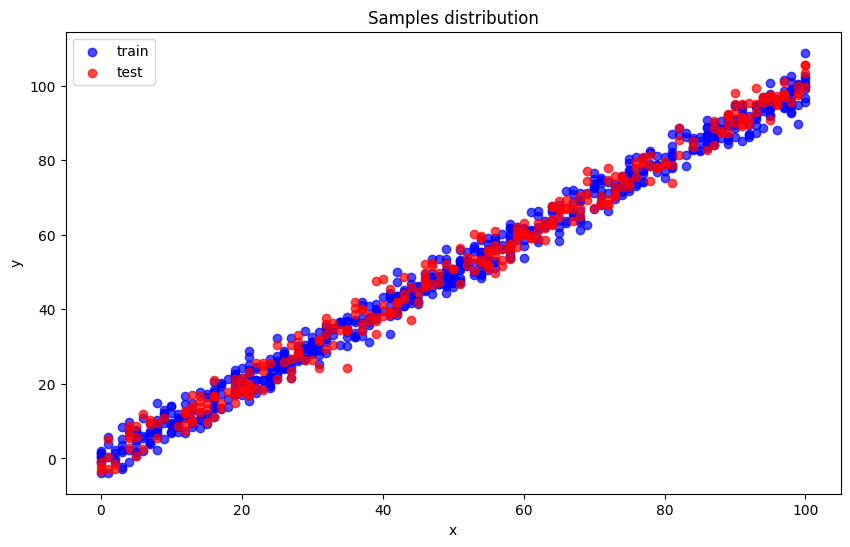

In [3]:
fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(train['x'], train['y'], c='blue', alpha=0.7, label='train')
ax.scatter(test['x'], test['y'], c='red', alpha=0.7, label='test')
ax.set_title("Samples distribution")
ax.set_xlabel('x')
ax.set_ylabel('y')

ax.legend()
plt.show()

In [4]:
train.describe()

,x,y
count,700.000000,699.000000
mean,54.985939,49.939869
std,134.681703,29.109217
min,0.000000,-3.839981
25%,25.000000,24.929968
50%,49.000000,48.973020
75%,75.000000,74.929911
max,3530.157369,108.871618


In [5]:
test.describe()

,x,y
count,300.000000,300.000000
mean,50.936667,51.205051
std,28.504286,29.071481
min,0.000000,-3.467884
25%,27.000000,25.676502
50%,53.000000,52.170557
75%,73.000000,74.303007
max,100.000000,105.591837


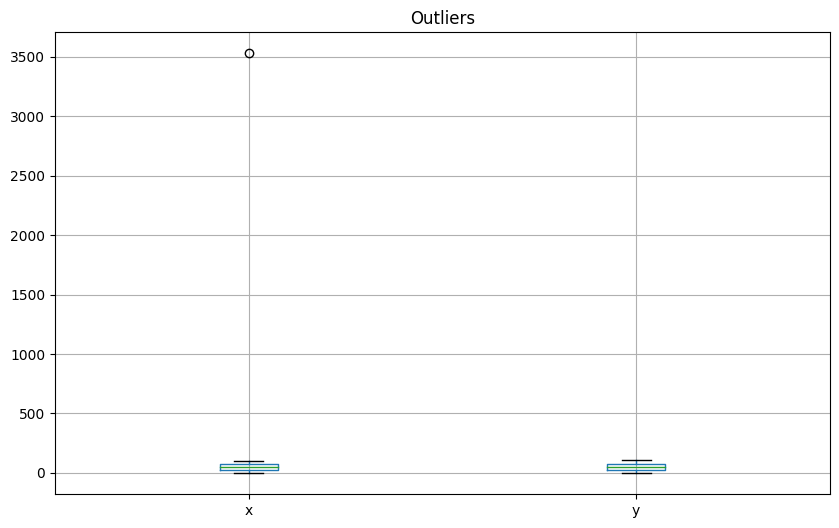

In [6]:
fig, ax = plt.subplots(figsize=(10,6))

train.boxplot()
ax.set_title('Outliers')

plt.show()

### Data Cleaning

Due to the simplicity of the dataset, there is almost nothing to clean. However, it is always a good practice to remove missing values and outliers.

In [7]:
train.isnull().sum().any(), test.isnull().sum().any()

(True, False)

Removing the null value in the training set.

In [8]:
train=train.dropna()
train.isnull().sum().any()

False

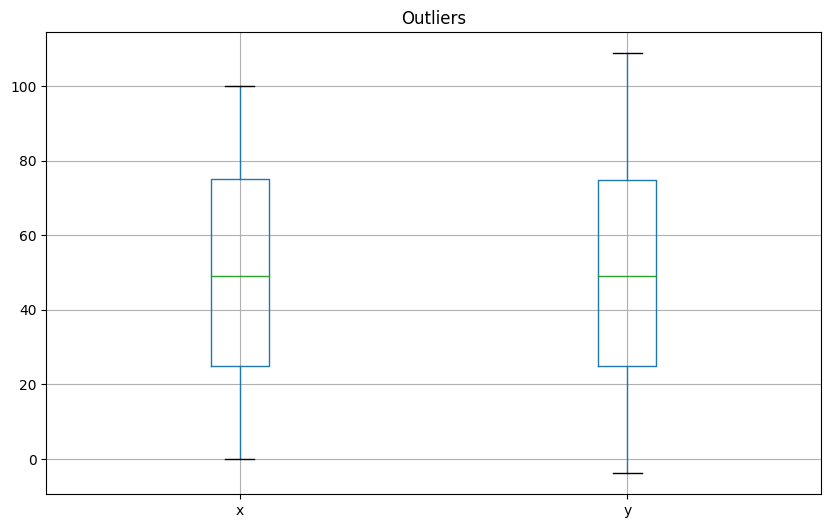

In [9]:
for col in train.columns:
        Q1 = train[col].quantile(0.25)
        Q3 = train[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        train = train[(train[col] >= lower_bound) & (train[col] <= upper_bound)]
        
fig, ax = plt.subplots(figsize=(10,6))

train.boxplot()
ax.set_title('Outliers')

plt.show()

Model made using PyTorch only works with tensors, so we need to convert the data to tensors. We will also split the data into training and test sets. In this case, it was needed to unsqueeze the data to make it work with our model (its shape has to be [_, 1]).

In [10]:
X_train = torch.tensor(train['x'].values).type(torch.float).unsqueeze(dim=1)
y_train = torch.tensor(train['y'].values).type(torch.float).unsqueeze(dim=1)

X_test = torch.tensor(test['x'].values).type(torch.float).unsqueeze(dim=1)
y_test = torch.tensor(test['y'].values).type(torch.float).unsqueeze(dim=1)

X_train[:4], X_test[:4]

(tensor([[24.],
         [50.],
         [15.],
         [38.]]),
 tensor([[77.],
         [21.],
         [22.],
         [20.]]))

In [11]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([699, 1]),
 torch.Size([699, 1]),
 torch.Size([300, 1]),
 torch.Size([300, 1]))

### Model

As mentioned before, the model used is a simple linear regression. The model is defined as a class that inherits from the nn.Module class. In this case, there is only one layer, a linear layer with one input and one output (enough to handle our problem). The forward method defines how the data flows through the layers of the model. In this case, the data flows through the linear layer.

In [12]:
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(in_features=input_size, out_features=output_size)
    
    def forward(self, x):
        return self.layer1(x)
    
    def predict(self, x):
        return self.forward(x)

A manual seed is set to avoid different results between equal runs.

In [13]:
torch.manual_seed(9)
n_samples, n_features = X_train.shape[0], X_train.shape[1]

model_0 = LinearRegression(n_features, n_features)
model_0.state_dict()

OrderedDict([('layer1.weight', tensor([[0.3116]])),
             ('layer1.bias', tensor([-0.3960]))])

To train the model, we need to define the loss function and the optimizer. The loss function used is the Mean Squared Error (MSE). The optimizer used is the Adaptive Moment Estimation (Adam). The learning rate is set to 0.01.

In [14]:
max_epochs = 200
lr = 0.01
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=lr)

loss_list = []
for epoch in range(1, max_epochs+1):
    model_0.train()
    y_pred = model_0(X_train)
    
    loss = loss_fn(y_pred, y_train)
    loss_list.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model_0.eval()
    with torch.inference_mode():
        test_pred = model_0(X_test)
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss.item()} | Test loss: {test_loss.item()}")

Epoch: 10 | Train loss: 1219.6484375 | Test loss: 1238.1009521484375
Epoch: 20 | Train loss: 856.4905395507812 | Test loss: 870.4414672851562
Epoch: 30 | Train loss: 573.5510864257812 | Test loss: 584.7201538085938
Epoch: 40 | Train loss: 365.5591125488281 | Test loss: 374.9931640625
Epoch: 50 | Train loss: 221.55123901367188 | Test loss: 229.76422119140625
Epoch: 60 | Train loss: 127.88209533691406 | Test loss: 135.05740356445312
Epoch: 70 | Train loss: 70.86611938476562 | Test loss: 77.03815460205078
Epoch: 80 | Train loss: 38.555015563964844 | Test loss: 43.736629486083984
Epoch: 90 | Train loss: 21.6175594329834 | Test loss: 25.866788864135742
Epoch: 100 | Train loss: 13.472169876098633 | Test loss: 16.907310485839844
Epoch: 110 | Train loss: 9.918274879455566 | Test loss: 12.699931144714355
Epoch: 120 | Train loss: 8.534465789794922 | Test loss: 10.83504581451416
Epoch: 130 | Train loss: 8.066287994384766 | Test loss: 10.043096542358398
Epoch: 140 | Train loss: 7.935345649719238 |

Whese are the weights after training the model:

In [15]:
model_0.state_dict()

OrderedDict([('layer1.weight', tensor([[0.9950]])),
             ('layer1.bias', tensor([0.2789]))])

Here is a graph showing the loss function value for each epoch, note that the loss function decreases as the number of epochs increases.

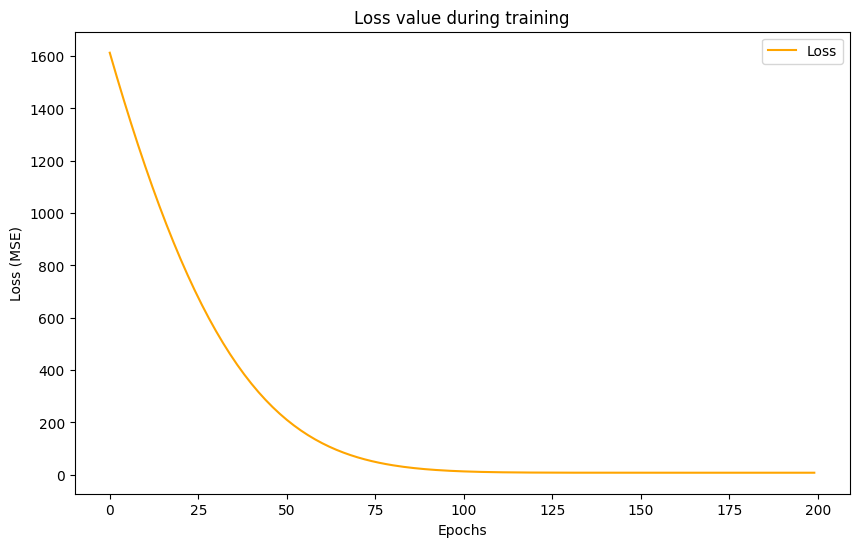

In [16]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(range(max_epochs), loss_list, c='orange', label='Loss')
ax.set_title("Loss value during training")
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss (MSE)')

ax.legend()
plt.show()

R-squared measures the proportion of the variance in the dependent variable (target) that is explained by the independent variables (features) in the model. It ranges from 0 to 1, with higher values indicating a better fit.

In [17]:
test_pred = model_0(X_test)

metric = R2Score()
metric.update(test_pred, y_test)
metric.compute()

tensor(0.9887)

Finally, we can plot the model and the data. The model is supposed to be a line that best fits the data.

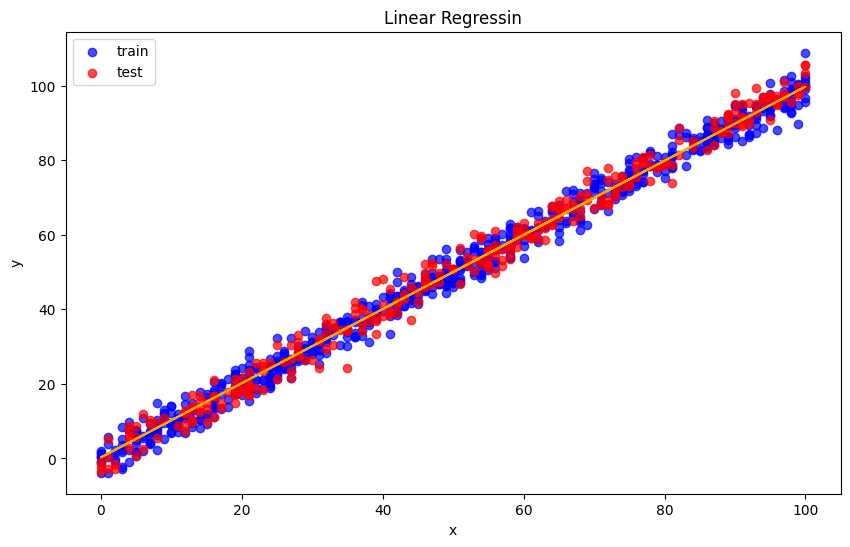

In [18]:
y_hat = model_0(X_test).detach().numpy()

fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(train['x'], train['y'], c='blue', alpha=0.7, label='train')
ax.scatter(test['x'], test['y'], c='red', alpha=0.7, label='test')
ax.plot(test['x'], y_hat, c='orange')
ax.set_title("Linear Regressin")
ax.set_xlabel('x')
ax.set_ylabel('y')

ax.legend()
plt.show()